### Train model in characters level

- Best model can achieve > 99.5% accuracy
- 3 convolutional layer and 1 dense layers



In [16]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
#from helpers import resize_to_fit
from keras.callbacks import EarlyStopping

LETTER_IMAGES_FOLDER = "extracted_letter_images_amazon"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# initialize the data and labels
data = []
labels = []


# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    
 
    
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    #image = resize_to_fit(image, 20, 20)
    image = cv2.resize(image,(20,20))
    ## Important !!! ###
    # Add a third channel dimension to the image to make Keras happy
    ## equal to reshape 
    
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

## Standardize and convert to np array
## convert list to array
data = np.array(data,dtype = 'float')/255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test,Y_train,Y_test) = train_test_split(data,labels,test_size=  0.2,random_state = 0)

## Convert the labels into one-hot encoding that Keras can fit

lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

## Save the mapping from labels to one-hot encodings
## 

with open(MODEL_LABELS_FILENAME,"wb") as f:
    pickle.dump(lb,f)
    
    
## CNN model start from here

model = Sequential()

## First convolutional layer with max pooling
model.add(Conv2D(20,(5,5),padding = "same",input_shape = (20,20,1),activation = "relu" ))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

### Second convolutional layer with max pooling

model.add(Conv2D(50,(5,5),padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model.add(Conv2D(80,(5,5),padding = "same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

## Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500,activation = "relu"))


model.add(Dense(800,activation = "relu"))

## Output layer with 18 nodes (one for each possible letter/number we predict)
model.add(Dense(18,activation = "softmax"))

### Compile

model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

## Early Stoping
EarlyStopping = EarlyStopping(monitor = 'val_loss',
                             patience = 5)


## train the neural network

train_history = model.fit(X_train, Y_train,validation_data = (X_test,Y_test),batch_size = 32,
                          epochs = 20,verbose = 1,
                         callbacks = [EarlyStopping])

model.save(MODEL_FILENAME)


Train on 3489 samples, validate on 873 samples
Epoch 1/20
3489/3489 [==============================] - 2s 715us/step - loss: 1.1401 - acc: 0.6543 - val_loss: 0.1274 - val_acc: 0.9759
Epoch 2/20
3489/3489 [==============================] - 2s 446us/step - loss: 0.1041 - acc: 0.9797 - val_loss: 0.1013 - val_acc: 0.9840
Epoch 3/20
3489/3489 [==============================] - 2s 445us/step - loss: 0.0743 - acc: 0.9851 - val_loss: 0.0859 - val_acc: 0.9863
Epoch 4/20
3489/3489 [==============================] - 2s 444us/step - loss: 0.0428 - acc: 0.9951 - val_loss: 0.0716 - val_acc: 0.9920
Epoch 5/20
3489/3489 [==============================] - 2s 444us/step - loss: 0.0392 - acc: 0.9960 - val_loss: 0.0700 - val_acc: 0.9931
Epoch 6/20
3489/3489 [==============================] - 2s 450us/step - loss: 0.0365 - acc: 0.9954 - val_loss: 0.0682 - val_acc: 0.9931
Epoch 7/20
3489/3489 [==============================] - 2s 447us/step - loss: 0.0386 - acc: 0.9940 - val_loss: 0.0828 - val_acc: 0.9897
E

## Plot to see the result 


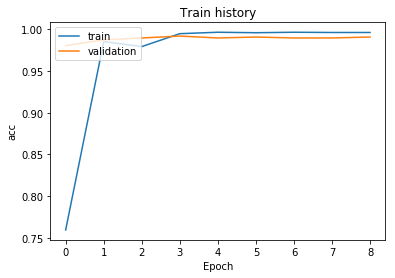

In [14]:

import matplotlib.pyplot as plt

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train history")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc = 'upper left')
    plt.show()
    
show_train_history(train_history,'acc','val_acc')